<a href="https://colab.research.google.com/github/SRIJAREDDYANUGU/majorproject/blob/main/Major_execution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Upload Kaggle API Key**

In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"srijareddyanugu","key":"1135830e36f042552ce424995e7a8f9b"}'}

Set Up Kaggle API and **Permissions**

In [ ]:
# Make a directory and move the JSON file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Set permissions
!chmod 600 ~/.kaggle/kaggle.json


 Download the Dataset from Kaggle

In [ ]:
# Download dataset (you can change the dataset slug if needed)
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images


Dataset URL: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images
License(s): CC-BY-SA-4.0
lung-and-colon-cancer-histopathological-images.zip: Skipping, found more recently modified local copy (use --force to force download)


unzip it

In [ ]:
# Unzip the dataset
!unzip lung-and-colon-cancer-histopathological-images.zip -d colon_cancer_data


Archive:  lung-and-colon-cancer-histopathological-images.zip
replace colon_cancer_data/lung_colon_image_set/colon_image_sets/colon_aca/colonca1.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Check Directory Contents

In [ ]:
!ls


 colon_binary_data	  'kaggle (1).json'				        sample_data
 colon_binary_data_split   kaggle.json
 colon_cancer_data	   lung-and-colon-cancer-histopathological-images.zip


Set Directory Paths

In [ ]:
train_dir = "/content/Colon Cancer Dataset/train"
test_dir = "/content/Colon Cancer Dataset/test"


In [ ]:
!ls /content


 colon_binary_data	   colon_cancer_data   kaggle.json
 colon_binary_data_split   colonn10.jpeg       lung-and-colon-cancer-histopathological-images.zip
 colonca1.jpeg		  'kaggle (1).json'    sample_data


In [ ]:
!ls /content/colon_binary_data_split


test  train


In [ ]:
train_dir = "/content/colon_binary_data_split/train"
test_dir = "/content/colon_binary_data_split/test"


Prepare Data Using ImageDataGenerator

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = 224
batch_size = 32

train_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary'
)

test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary'
)


Found 1690 images belonging to 2 classes.
Found 540 images belonging to 2 classes.


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [ ]:
# Set image size and batch size
img_size = 224
batch_size = 32

# Set directory paths
train_dir = "/content/colon_binary_data_split/train"
test_dir = "/content/colon_binary_data_split/test"

# Data generators with normalization
train_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary'
)

test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary'
)


Found 1690 images belonging to 2 classes.
Found 540 images belonging to 2 classes.


Build ResNet50-Based Model

In [ ]:
# Load ResNet50 base
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom layers on top
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])


Compile the Model

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [ ]:
from PIL import Image
import os

def remove_corrupt_images(folder_path):
    removed = 0
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # Verify if it's an image
            except Exception as e:
                print(f"Removing corrupt file: {file_path}")
                os.remove(file_path)
                removed += 1
    print(f"Total corrupt images removed: {removed}")

# Clean train and test folders
remove_corrupt_images('/content/colon_binary_data_split/train')
remove_corrupt_images('/content/colon_binary_data_split/test')


Removing corrupt file: /content/colon_binary_data_split/train/tumor/colonca4118.jpeg
Total corrupt images removed: 1
Total corrupt images removed: 0


Train the Model

In [ ]:
train_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    '/content/colon_binary_data_split/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    '/content/colon_binary_data_split/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Re-train
history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=10,
    callbacks=[early_stop]
)


Found 1689 images belonging to 2 classes.
Found 540 images belonging to 2 classes.
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 446s 8s/step - accuracy: 0.5293 - loss: 0.6843 - val_accuracy: 0.7389 - val_loss: 0.6656
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 430s 8s/step - accuracy: 0.6944 - loss: 0.6631 - val_accuracy: 0.7611 - val_loss: 0.6470
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 434s 8s/step - accuracy: 0.6656 - loss: 0.6524 - val_accuracy: 0.7648 - val_loss: 0.6297
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 432s 8s/step - accuracy: 0.7156 - loss: 0.6287 - val_accuracy: 0.6870 - val_loss: 0.6209
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 474s 9s/step - accuracy: 0.7316 - loss: 0.6144 - val_accuracy: 0.7667 - val_loss: 0.6004
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 430s 8s/step - accuracy: 0.7480 - loss: 0.5964 - val_accuracy: 0.7259 - val_loss: 0.5926
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 437s 8s/step - accuracy: 0.7297 - loss: 0.5894 - val_accuracy: 0.7574 - val_loss: 0.5801
Epoch 8/10
53/53 ━━━━━━━━━━━

Evaluate the Model

In [ ]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


17/17 ━━━━━━━━━━━━━━━━━━━━ 109s 6s/step - accuracy: 0.7310 - loss: 0.5754
Test Accuracy: 74.63%
Test Loss: 0.5655


Upload an Image for Prediction

Saving colonca100.jpeg to colonca100.jpeg
Uploaded image path: colonca100.jpeg


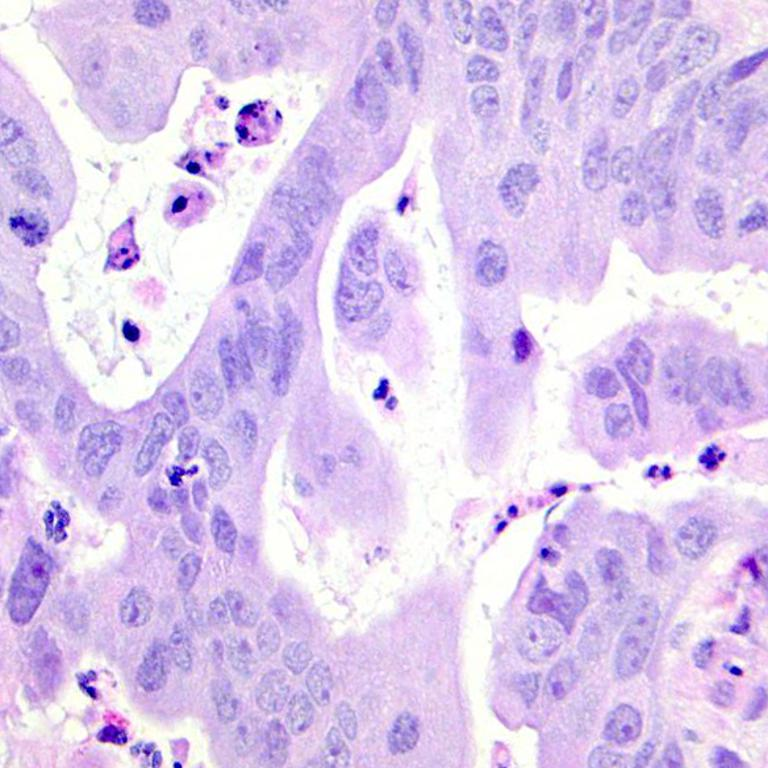

In [ ]:
from IPython.display import Image, display

from google.colab import files

# Upload image
uploaded = files.upload()

# Get uploaded file name
image_path = list(uploaded.keys())[0]
print(f"Uploaded image path: {image_path}")

# Display the uploaded image
display(Image(filename=image_path))


Predict on Uploaded Image

In [ ]:
from keras.utils import load_img, img_to_array
import numpy as np

# Load and preprocess uploaded image
img = load_img(image_path, target_size=(224, 224))  # Match model input size
img_array = img_to_array(img) / 255.0               # Normalize
img_array = np.expand_dims(img_array, axis=0)       # Add batch dimension

# Predict
prediction = model.predict(img_array)
predicted_class = "Tumor" if prediction[0][0] > 0.5 else "Non-Tumor"
print(f"🧠 Prediction Result: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
🧠 Prediction Result: Tumor


Display Result and Redirect (if Tumor)

In [ ]:
from IPython.display import display, HTML

if predicted_class == "Tumor":
    print("⚠️ Tumor Detected. Redirecting to hospital form...")

    # Your hospital Google Form link
    hospital_form_url = "https://forms.gle/QLypuj8LdhKCGo7r6"

    # Show the clickable link
    display(HTML(f"<a href='{hospital_form_url}' target='_blank'>📝 Click here for hospital registration</a>"))
else:
    print("🎉 No tumor detected. Stay healthy and safe!")


⚠️ Tumor Detected. Redirecting to hospital form...
